In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##  Data pre-processing

In [2]:
df = pd.read_csv('all-posts-public-main-chatroom/freecodecamp_casual_chatroom.csv', usecols = ['fromUser.id', 'text'])
df = df[df['fromUser.id'] != '55b977f00fc9f982beab7883'] 

In [3]:
df.head()

fromUser.id                                               text
0  546fd99cdb8155e6700d6ec8                                  no legumes either
1  54a47e0cdb8155e6700e486e            That bullet proof coffee sounds insane.
2  54a47e0cdb8155e6700e486e                            That guy has huge eyes.
3  546fd99cdb8155e6700d6ec8  @janetwalters008 It is. but it works. some peo...
4  54a44bbbdb8155e6700e47de  They guy that came up with the idea is kind of...

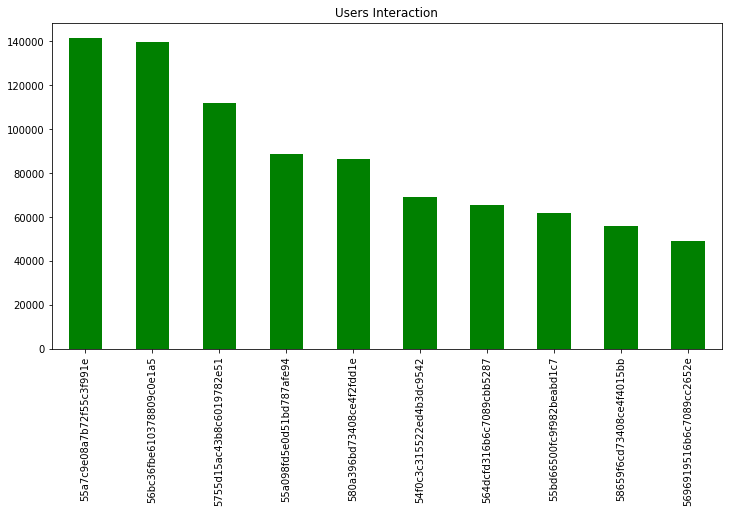

In [7]:
# Visualize activity of users
f, g = plt.subplots(figsize=(12, 6))
df['fromUser.id'].value_counts().head(10).plot.bar(color="green")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Users Interaction")
plt.show(g)

<br>
<font size='4' color='green' > We will train out model on the most active user, who has around 140000 messages . We only need a subset of these messages to generate word sequences so taking 25% of the text. For Text Generation, we will be predicting characters and not words so it's important for our model to understand the character sequences.</font>

<font size='4'>We will train out model on the most active user, who has around 140000 messages . We only need a subset of these messages to generate word sequences so taking 25% of the text. For Text Generation, we will be predicting characters and not words so it's important for our model to understand the character sequences.</font>

In [13]:
# Get messages of top user
messages =df[df['fromUser.id'] == '55a7c9e08a7b72f55c3f991e']['text']
print('Number of messages by top user: ',len(messages))

# get 25% of a message
size = int(len(messages)*0.25)

# join the messages 
messages = messages[:size]
print('Number of messages considered: ', len(messages))
messages = " ".join(map(str,messages)).lower()

Number of messages by top user:  141362
Number of messages considered:  35340


In [14]:
# Map the characters to indices
characters = sorted(list(set(messages)))
# print('Count of unique characters (i.e., features):', len(chars))
char_indices = dict((c, i) for i, c in enumerate(characters))
indices_char = dict((i, c) for i, c in enumerate(characters))

In [18]:
# Prepare dependent and independent variables 
max_length = 50
step = 3
current_sen = []
next_char = []

for i in range(0, len(messages)-max_length, step):
    current_sen.append(messages[i: i + max_length])
    next_char.append(messages[i+max_length])
print('Sunset of original message: ',messages[:60])
print('Independent Variable: ',current_sen[0])
print('Dependent Variable: ',next_char[0])

Sunset of original message:  hello... i heard about free code camp via lifehacker (i thin
Independent Variable:  hello... i heard about free code camp via lifehack
Dependent Variable:  e


In [20]:
# Get the sparse boolean vector representation
x = np.zeros((len(current_sen), max_length, len(characters)), dtype=np.bool)
y = np.zeros((len(current_sen), len(characters)), dtype=np.bool)
for i, sentence in enumerate(current_sen):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_char[i]]] = 1

## LSTM-Keras

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.callbacks import LambdaCallback, ModelCheckpoint
import random
import sys
import io

/Users/ajaysingh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
# Define LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(max_length, len(characters))))
model.add(Dense(len(characters)))
model.add(Activation('softmax'))

In [19]:
# Compile the model
optimizer = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

<br>
<font size="3" color='green'>Now, let's define some helper functions. The first one in sample(), which returns an index for preds and temperature value. __Temperature__ is a scaling factor, applied to the final layer before applying actication function. Lower the temperature value, more the conservative/safe predictions it will make whereas higher temperature value will lead to riskier/creative guesses.
<br>
The second one is a callback function which generates/predicts the character for a random message for different values of 'temperatures' after the first epoch and last epoch. </font>
<br>

In [21]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)
       
def on_epoch_end(epoch, logs):
    # Function invoked for specified epochs. Prints generated text.
    # Using epoch+1 to be consistent with the training epochs printed by Keras
    if epoch+1 == 1 or epoch+1 == 10:
        print()
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = random.randint(0, len(messages) - max_length - 1)
        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print('----- diversity:', diversity)

            generated = ''
            sentence = messages[start_index: start_index + max_length]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, max_length, len(characters)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()
    else:
        print()
        print('----- Not generating text after Epoch: %d' % epoch)

generate_text = LambdaCallback(on_epoch_end=on_epoch_end)

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               142336    
_________________________________________________________________
dense_1 (Dense)              (None, 149)               19221     
_________________________________________________________________
activation_1 (Activation)    (None, 149)               0         
Total params: 161,557
Trainable params: 161,557
Non-trainable params: 0
_________________________________________________________________


In [22]:
%%time
# Train model
filepath = "weight.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
model.fit(x, y,
              batch_size=256,
              epochs=10,
              verbose=2,
              callbacks=[generate_text, checkpoint])

Epoch 1/10
 - 671s - loss: 2.0749

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "eiselems how are you running all the other things "
eiselems how are you running all the other things the comment the stuff it the stuff it the compenting the the seme a seres with the setting the comperbot the the seme of the because it the starting in the semperbot the start the the see i think you was in the stuff it the seever it for the a some the servision the servision  @allisertore  the comment the stuff it in the stuff it see it's the stuff it would be a bot the stuff it to go the startin
----- diversity: 0.5
----- Generating with seed: "eiselems how are you running all the other things "
eiselems how are you running all the other things the tome the mide in the talking it for project wow the for the the in the the a back a lot of the least that i was lol it's that it the tome the the semper pasted the setting yeah, it the penst to compenting of some someth

/Users/ajaysingh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


e stane the state the same the something the the an extra i think you can be a lot of the same the back to be a server in the format the code code on the something the an other the and starbucks the data the same the start of the same the start of the what i think it was a basing the state the code in the start and the code the standant 
----- diversity: 0.5
----- Generating with seed: "sing an api (not 'hardcoded' quotes) but to get a "
sing an api (not 'hardcoded' quotes) but to get a deple of the head the usent (i want a lol i use the same the case of the from the js and means really the camperbot in (the from camperbot (i want a does the something to comment of the that in the standanity the factored but and be in a gramment of the language i want a busite (i.e., good the bad is a pretty exercise that not the camperbot code sense in the last the state an interesting interview
----- diversity: 1.0
----- Generating with seed: "sing an api (not 'hardcoded' quotes) but to get a "
sing 

<font size='4' color='green'>From epoch 1 to epoch 10, it seems our model has improved its prediction. In epoch 1, the predicted text hardly resembles English whereas for epoch 10, the words generated are English words. Hence, the model could learn from the first epoch to the last. Predictions for epoch 10 still don't make much sense because here we are only running 10 epochs due to computation limitaion (training on CPU). Results will be much better for epochs 20 or more.</font>